# Outliers & Univariate EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import skimage.io
import wordcloud
%matplotlib inline

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

conn_str = f'postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}'
engine = create_engine(conn_str)

query = """
SELECT *
FROM youtube
"""                       
                       
youtube_df = pd.read_sql_query(query, con=engine)
engine.dispose()
youtube_df.head()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


## Identifying Outliers

### Eyeballing

We can just try and look through the data to see outliers... This doesn't work too well...

In this data we have a huge range of values, from just seeing the head and the tail we can't tell if the high numbers are outliers, the low numbers are outliers, or if it smoothly covers the full range.

In [2]:
youtube_df['Video views'].sort_values()

2405             75
326             350
1294           8496
1350           9495
2973          74014
           ...     
3       22675948293
6       23898730764
8       24518098041
4       26273668433
1       47548839843
Name: Video views, Length: 5000, dtype: int64

### Visualization

A better way would be to use one of the distribution visualizations we know.  Some examples using `seaborn` are shown below.

##### Tangent about timing code

The `sns.swarmplot()` that we've seen before can be pretty slow with many obersations, and is omitted because of this.  You can confirm the speed of the plotting using `timeit`.  To run `timeit` on a line of code, you put `%timeit` at the begininning of the line; see example below.

Input:

```python
%timeit -n 1 sns.swarmplot(youtube_df['Video views'][:1000])
```

Output:

```
3.65 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

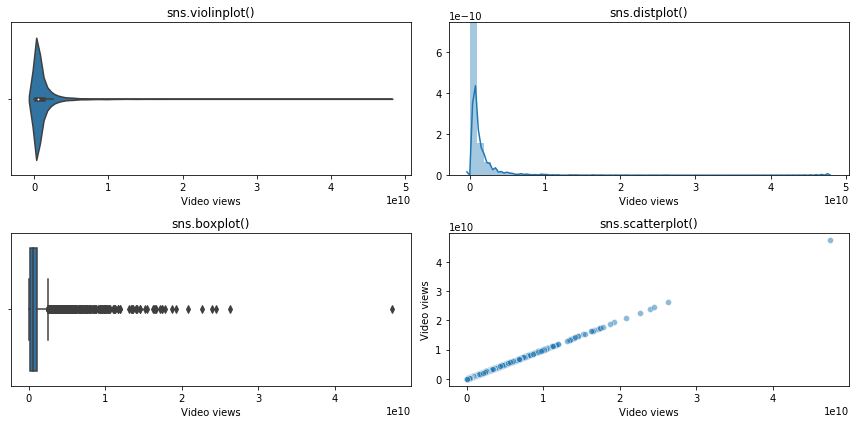

In [3]:
fig, axes = plt.subplots(2, 2, sharey=False)

sns.violinplot(youtube_df['Video views'], ax=axes[0, 0])
sns.distplot(youtube_df['Video views'], ax=axes[0, 1])
sns.boxplot(youtube_df['Video views'], ax=axes[1, 0])
sns.scatterplot(youtube_df['Video views'], 
                youtube_df['Video views'], 
                ax=axes[1, 1],
                alpha=0.5)

axes[0, 0].set_title('sns.violinplot()')
axes[0, 1].set_title('sns.distplot()')
axes[1, 0].set_title('sns.boxplot()')
axes[1, 1].set_title('sns.scatterplot()')

fig.set_size_inches(12, 6)
fig.tight_layout()

### Cutoff values

#### Z scores

To be a little more formal we could look into calculating $z$ scores for our observations.

The `scipy.stats` module has a function for calculating this, but there's also a custom implementation below to see what's actually being done.  In english, the formula is, for each observation, subtract the mean and divide by the standard deviation.  Intuitively, a $z$ score tells you how many standard deviations from the mean each observation is.

##### By 'hand' example

In [4]:
sample = np.array([1, 2, 3, 4, 5, 6, 25])
mean = sample.mean()
std = sample.std()
z_scores = (sample - mean) / std

largest_z_filter = np.where(z_scores == z_scores.max())
largest_z = z_scores[largest_z_filter][0]
largest_z_value = sample[largest_z_filter][0]

print(f'The mean is {mean:.2f} & the std dev is {std:.2f}')
print(f'The largest z-score is {largest_z:.2f} the corresponding value is {largest_z_value}.')
print('\nSince our z-score is just a measure of how far each observation is from the mean, '
      'we can recalculate the original values from the zcores, mean, and std.')
print(f'mean + z_score * std = {mean:.2f} + {largest_z:.2f} * {std:.2f} = {mean + largest_z * std}')

The mean is 6.57 & the std dev is 7.69
The largest z-score is 2.40 the corresponding value is 25.

Since our z-score is just a measure of how far each observation is from the mean, we can recalculate the original values from the zcores, mean, and std.
mean + z_score * std = 6.57 + 2.40 * 7.69 = 25.0


##### Using functions

So we can calculate these scores; so what?  With the scores, you can decide on a threshold that indicates just how far you want your data to go.  There's no perfect rule-of-thumb value.  If using this method, try some values and see how it affects your data (i.e. cuts out too much of the data as outliers? not enough?)

In [5]:
def z_scores(sample):
    return (sample - sample.mean()) / sample.std()

scipy_z = stats.zscore(youtube_df['Video views'])
homebrew_z = z_scores(youtube_df['Video views'])

# Pretty close, not exactly the same.  Close enough in practice to be considered equal.
print(scipy_z[:5])
print(homebrew_z.values[:5])

# Officially test that we're in the same ball park for scores
print(f'\nAll difference <= 0.003?: {np.allclose(scipy_z, homebrew_z, atol=0.003)}')

[ 9.8811672  23.19643621  4.3529976  10.78260582 12.5781947 ]
[ 9.88017903 23.19411645  4.35256228 10.7815275  12.57693682]

All difference <= 0.003?: True


#### IQR

The interquartile range can also be used with some thresholding to decide whats an outlier.  This is how boxplots typically decide which points are outliers.  See reading for more...

### Handling outliers

Before you do anything about outliers you want to be intimately familiar with the data.  Why are there outliers? are they valid? do the outliers affect the analysis? how?

Let's say we're trying to predict the amount someone will spend on dinner. To do this, we have a database of their dinner spending for the past year - 1 entry for each day of the year.  In our data, we see 1 outlier that has a really large dinner cost.  We decide to drop it from our dataset and we have our model predict the next year's dinner costs.  We see that are model performed well except for 1 day where we underpredicted, and it turns out to be the same date as last year's outlier that was dropped.  In this example, maybe the day is our subject's birthday, and if we took this feature into account, maybe we could have actively predicted the cost.

This is, of course, a contrived example.  You need to weigh the costs/benefits of dropping/modifying outliers in light of your goals for the project.

Quote from John Tukey (super smart/influential stats guy):

> Sets of observations which have been de-tailed by over-vigorous use of a rule for rejecting outliers are inappropriate, since they are not samples.

Quote from Francis Bacon (maybe quote.. maybe paraphrase.. can't find good source)

> We learn once when we establish the general rule, and learn again when we investigate the exceptions.

#### Strategies covered in the reading

* Drop outliers (know the impact of the info you're removing before doing so)
* Winsorization (know the impact of the info you're adjusting before doing so)
* Transformation (keeps all information/observations)

#### Example

Let's start by exploring 2 common transformations for data.  We can apply them and then plot them to see how they affect the distribution.

In [6]:
log_views = np.log(youtube_df['Video views'])
sqrt_views = np.sqrt(youtube_df['Video views'])

# With a boxcox transform a parameter (lambda), can be adjusted
# We can adjust this parameter until our data is the most normal
# scipy.stats.boxcox() allows you to choose a value for lambda
# but if you don't pass a value it will pick the one that leads
# to the most normal results.
boxcox_views, best_lmbda = stats.boxcox(youtube_df['Video views'])
print(f'best_lmbda: {best_lmbda:.4f}')

best_lmbda: 0.1097


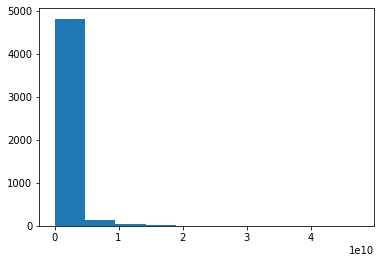

In [7]:
plt.hist(youtube_df['Video views'])
plt.show()

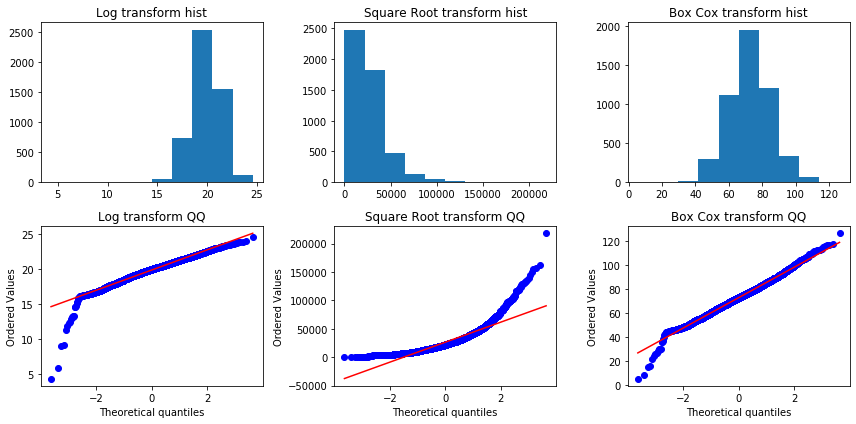

In [8]:
fig, axes = plt.subplots(2, 3)

axes[0, 0].hist(log_views)
axes[0, 1].hist(sqrt_views)
axes[0, 2].hist(boxcox_views)
stats.probplot(log_views, dist='norm', plot=axes[1, 0])
stats.probplot(sqrt_views, dist='norm', plot=axes[1, 1])
stats.probplot(boxcox_views, dist='norm', plot=axes[1, 2])

axes[0, 0].set_title('Log transform hist')
axes[0, 1].set_title('Square Root transform hist')
axes[0, 2].set_title('Box Cox transform hist')
axes[1, 0].set_title('Log transform QQ')
axes[1, 1].set_title('Square Root transform QQ')
axes[1, 2].set_title('Box Cox transform QQ')

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

The Box Cox transform we used is intentionally tuned to be as normal as possible while keeping all the data, and the log transform is starting to look a little normal.

##### An aside about Box Cox

---

*Disclaimer: this went on a little rabbit trail, and Box Cox isn't really the focus of this lecture.  Leaving it in for some example code.*

*To jump to back on topic... click [here](#Moving-on...).*

---

First, to be formal, we could look at some math.  Below is the Box Cox transformation.  $y$ is the input data, $\lambda$ is a parameter we can use to adjust the output (often lambda is adjusted until the output is the most normal).

This only works when $y$ is positive though... why?  Hint, look at the case when $\lambda$ is 0.

$$y(\lambda) = 
\begin{cases}
\frac{y^{\lambda} - 1}{\lambda}, \quad \text{if} \lambda \neq 0; \\
log(y), \space\space\text{if} \lambda = 0.
\end{cases}$$

To overcome the issue with negatives we can simply shift them by adding a value.  This parameter is formally called $\lambda_2$, but we won't look at the math. 

In [9]:
def boxcox(x, lmbda, lmbda_2=0):
    y = x.copy()
    y += lmbda_2
    
    if lmbda == 0:
        return np.log(y)
    else:
        return (y**lmbda - 1) / lmbda

---

*Disclaimer: this went on a little rabbit trail, and Box Cox isn't really the focus of this lecture.  Leaving it in for some example code.*

*To jump to back on topic... click [here](#Moving-on...).*

---

In the above function, we've implemented the $\lambda_2$ parameter.  As you can see, what we're doing is shifting the distribution by adding the number to every value of our original distribution.  In practice, we can set this value based on our largest negative number to ensure everything is positive.  After this shifting is done, we see the normal Box Cox formula.

For example, if we have `[-1, -2, -3, -4]`, we could set $lambda_2$ to `-5` and our new input data to transform would be `[4, 3, 2, 1]`.

The below example looks at how different values of lambda affect the same distribution.

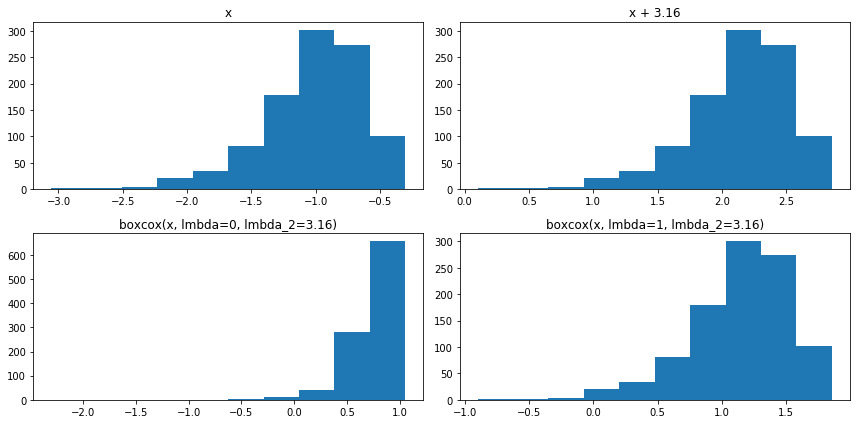

In [10]:
# Generate some random data that consists of negative values
np.random.seed(42)
x = -np.random.f(21, 42, size=1000)

# Make up a lambda_2 that makes our data positive
lmbda_2 = max(abs(x)) + 0.1

# See what a couple different lambdas look like
x1 = x + lmbda_2
x2 = boxcox(x, lmbda=0, lmbda_2=lmbda_2)
x3 = boxcox(x, lmbda=1, lmbda_2=lmbda_2)

# Viz original data, lambda_2 shift, and 2 boxcox transformed dists
fig, axes = plt.subplots(2, 2)
axes[0, 0].hist(x)
axes[0, 0].set_title('x')

axes[0, 1].hist(x1)
axes[0, 1].set_title(f'x + {lmbda_2:.2f}')

axes[1, 0].hist(x2)
axes[1, 0].set_title(f'boxcox(x, lmbda=0, lmbda_2={lmbda_2:.2f})')

axes[1, 1].hist(x3)
axes[1, 1].set_title(f'boxcox(x, lmbda=1, lmbda_2={lmbda_2:.2f})')

fig.set_size_inches((12, 6))
fig.tight_layout()
plt.show()

---

*Disclaimer: this went on a little rabbit trail, and Box Cox isn't really the focus of this lecture.  Leaving it in for some example code.*

*To jump to back on topic... click [here](#Moving-on...).*

---

Reminder about the disclaimer that this content on Box Cox is a little off topice and totally skipable.  But... lastly, below is an example of how one might implement a custom $\lambda$ search.

We'll loop over different values of $\lambda$, and perform the transform on our data.  We'll then generate a random normal sample, where the normal distribution has the same mean and standard deviations as our transformed data.  Lastly, we'll sort and correlate the 2 sets of data.  We'll say the lambda that leads to the largest correlation is the winner.  We'll implement this logic and then compare it to what scipy would do.

The results is that we're pretty close

     lmbda  pearson_r
153   2.65   0.998425
148   2.40   0.998419
142   2.10   0.998375
159   2.95   0.998298
165   3.25   0.998115


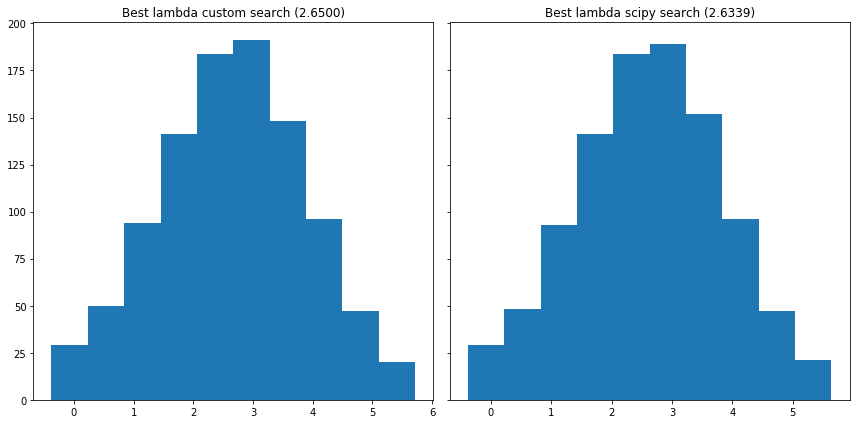

In [11]:
np.random.seed(42)

# Let's try and optimize lambda to give us the most normal output
# We'll generate a random normal with the same mean & standard dev
# as our transformed data.  Then we'll look at how correlated they are.
# We'll say the highest correlation is the most normal.
lmbdas = np.round(np.arange(-5, 5, 0.05), 2)
corrs = []
for lmbda in lmbdas:
    # Transform
    x_trans = boxcox(x, lmbda=lmbda, lmbda_2=lmbda_2)
    
    # Generate a related normal sample
    norm_sample = np.random.normal(x_trans.mean(), 
                                   x_trans.std(), 
                                   len(x_trans))
    
    # Sort and correlate
    x_trans.sort()
    norm_sample.sort()
    r, _ = stats.pearsonr(x_trans, norm_sample)
    
    # Store what we learned
    corrs.append(r)

# Largest correlation coef wins
lmbda_df = pd.DataFrame({'lmbda': lmbdas, 'pearson_r': corrs})
lmbda_df = lmbda_df.sort_values('pearson_r', ascending=False)
print(lmbda_df.head())

# Subset out lambda most correlated with normal and transform
best_lmbda_custom = lmbda_df['lmbda'].iloc[0]
x4 = boxcox(x, lmbda=best_lmbda_custom, lmbda_2=lmbda_2)

# What Would Scipy Do?
best_lmbda_scipy = stats.boxcox_normmax(x + lmbda_2)
x5 = stats.boxcox(x + lmbda_2, lmbda=best_lmbda_scipy)

fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(x4)
axes[0].set_title(
    f'Best lambda custom search ({best_lmbda_custom:.4f})'
)

axes[1].hist(x5)
axes[1].set_title(
    f'Best lambda scipy search ({best_lmbda_scipy:.4f})'
)

fig.set_size_inches((12, 6))
fig.tight_layout()
plt.show()

##### Moving on...

If you followed that Box Cox tangent, remember that originally, what we wanted to do was transform our YouTube data to  be a little more normal.  We had used a couple different transforms on the views column and they were starting to look normal.  The only issues were some weird tails in the left hand side of our QQ plot.  But, all we have done at this point is a transform.

It's important to remember you're not limited to a single strategy.  It looks like we're almost normal with the log transform (which is a big plus for a lot of our methods).  We have a little left skew, we could see what dropping extreme outliers with a z-score method might do.  We'll use a fairly conservative cutoff value of 3.

Our results show that we only lose 19 of our 5000 observations; this removal rate of 0.3% is not bad at all, especially since our data is now normal for most intents and purposes.

There were 19 observations removed by z-score.


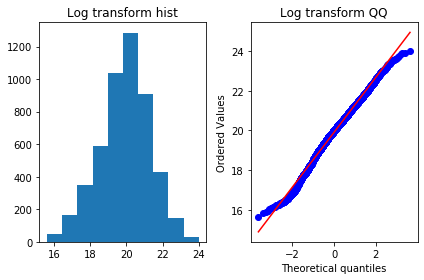

In [12]:
z_scores = stats.zscore(log_views)
outlier_filter = np.where(abs(z_scores) <= 3)
filtered_log_views = log_views.values[outlier_filter]

# Show count of lost observations
print(f'There were {len(log_views) - len(filtered_log_views)} observations removed by z-score.')

# Re-check histogram and normal QQ plot
fig, axes = plt.subplots(1, 2)

axes[0].hist(filtered_log_views)
stats.probplot(filtered_log_views, dist='norm', plot=axes[1])

axes[0].set_title('Log transform hist')
axes[1].set_title('Log transform QQ')

fig.tight_layout()
plt.show()

We could apply the same methodology to the Box Cox transformed data as well.  Here we end up losing more observations.  When doing this transform, our method's were being informed by our outliers that we we're trying to cull in the first place.  In this case the log transform + outlier removal might be the best option, again, this decision should be informed by your use case.

There were 29 observations removed by z-score.


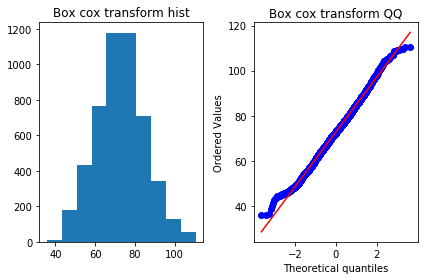

In [13]:
z_scores = stats.zscore(boxcox_views)
outlier_filter = np.where(abs(z_scores) <= 3)
filtered_boxcox_views = boxcox_views[outlier_filter]

# Show count of lost observations
print(f'There were {len(boxcox_views) - len(filtered_boxcox_views)} observations removed by z-score.')

# Re-check histogram and normal QQ plot
fig, axes = plt.subplots(1, 2)

axes[0].hist(filtered_boxcox_views)
stats.probplot(filtered_boxcox_views, dist='norm', plot=axes[1])

axes[0].set_title('Box cox transform hist')
axes[1].set_title('Box cox transform QQ')

fig.tight_layout()
plt.show()

Okay, we transformed a variable to be more normal, so what?

The example below shows that before we transform our data, we see little relationship between between uploads & views.  We then apply a log transform to both variables and we start to see a slight positive relationship.  In general, relationships between variables are a good sign if you're wanting to build a predictive model.

A negative of transforms is that their less intuitive to think about and interpret.  If we built a linear model to predict views given the number of uploads, we might discover that for every 10 uploads we expect 5 views.  However, if we've done log transforms to our data we lose a little bit of this interpretability; interpreting these types of models is [still doable](https://stats.stackexchange.com/a/18639/102646), but definitely less intuitive.  You need to weigh the pros/cons of the accuracy/interpretability trade-off when making modeling decisions.

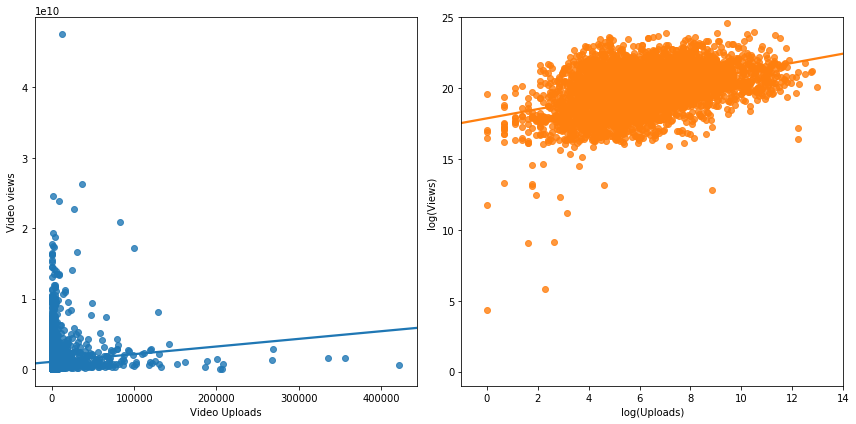

In [54]:
non_na_yt = youtube_df.copy()
non_na_yt = non_na_yt[['Video views', 'Video Uploads']]
non_na_yt['Video Uploads'] = pd.to_numeric(non_na_yt['Video Uploads'], errors='coerce')
non_na_yt = non_na_yt.dropna()

views = non_na_yt['Video views']
uploads = non_na_yt['Video Uploads']
log_views = np.log(views)
log_uploads = np.log(uploads)

fig, axes = plt.subplots(1, 2)

sns.regplot(uploads, views, ax=axes[0], ci=0)
sns.regplot(log_uploads, log_views, ax=axes[1], ci=0)

axes[1].set_xlabel('log(Uploads)')
axes[1].set_ylabel('log(Views)')
axes[1].set(xlim=(-1, 14), ylim=(-1, 25))

fig.set_size_inches((12, 6))
plt.tight_layout()
plt.show()

## Further EDA

What grades occurred the most? Which the least?  The reading uses `pandas` plot methods.  Below is an alternative example using `seaborn`

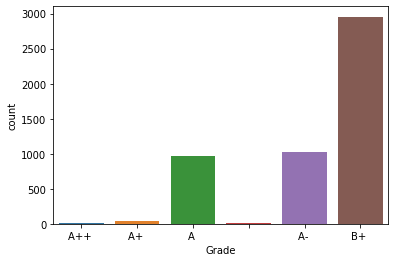

In [55]:
sns.countplot(youtube_df['Grade'])
plt.show()

Let's say we wanted to order the bars so that they go from highest to lowest grade. We could try to use the `order` argument... We see though that it fails... Why?

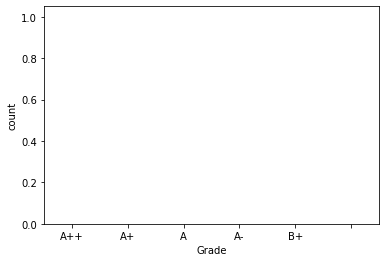

In [59]:
sns.countplot(youtube_df['Grade'], order=['A++', 'A+', 'A', 'A-', 'B+', ''])
plt.show()

Let's look at what values the `'Grade'` column holds just to make sure we copied them down correctly.  We see that we have some trailing whitespace, and a weird `\xa0` that wasn't showing up in our plot at all, but rather showing as blank.  A quick google of '\xa0' leads us to find out that `\xa0` is a non-breaking space in the Latin1 encoding.  You could do more research on what that is.

Every value has some trailing whitespace, and personally, I'd like to remove that and then view the output and go from there.  We can remove leading/trailing whitespace from a `pandas.Series` using `pandas.Series.str.strip()` like below.

The output shows that the non-breaking space was also handled by `strip()` so we don't have to worry about it.

In [62]:
print(youtube_df['Grade'].unique())
print(youtube_df['Grade'].str.strip().unique())

['A++ ' 'A+ ' 'A ' '\xa0 ' 'A- ' 'B+ ']
['A++' 'A+' 'A' '' 'A-' 'B+']


We can now apply this stripping to the column and get back to plotting.

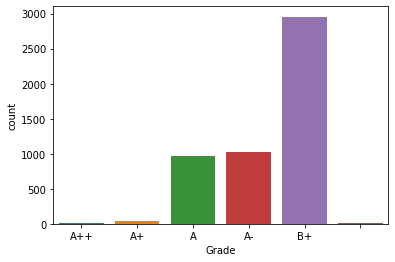

In [63]:
youtube_df['Grade'] = youtube_df['Grade'].str.strip()

sns.countplot(youtube_df['Grade'], order=['A++', 'A+', 'A', 'A-', 'B+', ''])
plt.show()

Below is just to show that the `wordcloud` package can produce prettier wordclouds than what was shown in the reading.  Remember that prettiness doesn't really factor into EDA though; save prettiness for presentations/reports/etc.

mask shape: (512, 512, 4)


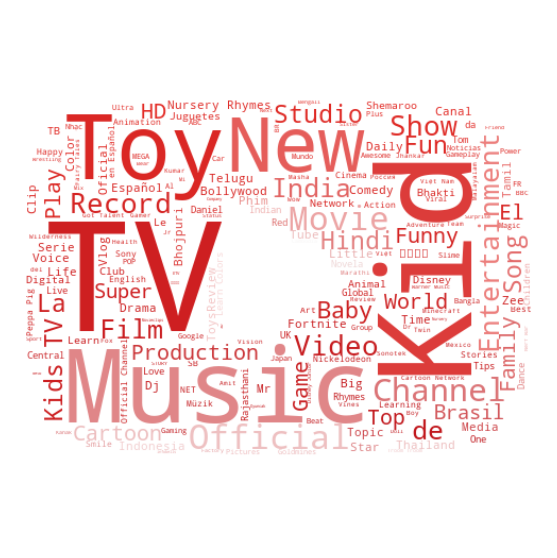

In [64]:
# Create text that will be analyzed
channel_name_text = " ".join(youtube_df["Channel name"])

# Download youtube logo to format wordcloud shape/color
# The mask will be a 3d numpy array: (height, width, [RGBA]); where RGBA = Red Green Blue Alpha
# The first 3 channels are RGB.  Black in RGB is (0, 0, 0); white is (255, 255, 255)
# The fourth channel is Alpha (aka Transparency).  0 is opaque; 255 is transparent.
mask = skimage.io.imread('https://seeklogo.net/wp-content/uploads/2016/06/YouTube-icon.png')
print(f'mask shape: {mask.shape}')

# After inspection we notice that alot of pixels have value (0, 0, 0, 0); aka opaque black
# We'd like these pixels to be transparent.  
# An easy way to do this is to set all these pixels to (255, 255, 255, 255); aka transparent white
mask[np.where(mask == [0, 0, 0, 0])] = 255

# Pass mask to WordCloud to shape our outputted plot
channel_wordcloud = wordcloud.WordCloud(background_color='white',
                                        mask=mask).generate(channel_name_text)

# Use mask and ImageColorGenerator to color our outputted plot
color_gen = wordcloud.ImageColorGenerator(mask)
channel_wordcloud = channel_wordcloud.recolor(color_func=color_gen)

plt.figure(figsize=(20,10))
plt.imshow(channel_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()